# Jordan Red Wine Quality Ensemble Models
**Author:** Jordan  
**Date:** November 21, 2025 <br>
**Objective:** Train and evaluate Gradient Boosting and AdaBoost endsemble models.


## Introduction
In this project, we use the UCI Red Wine Quality dataset. We will preprocess the data and train Gradient Boosting and AdaBoost classifier ensemble models using features based on physicochemical tests to predict the wine quality rating given by wine tasters.  Then, we will give comparisons of the models to each other and the models obtained from other team members.

## Imports
First, we import the necessary Python libraries for our analysis. 

In [833]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import clone
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.stats.stattools import medcouple

from stats_jordan import tukey_fences

## Section 1. Load and Inspect the Data

### 1.1 Load the Dataset
Next, we load the Insurance dataset into a dataframe and call the .info() and .head() methods to view the structure and initial rows of our data.

In [834]:
insurance_df = pd.read_csv("data/insurance.csv")
insurance_df.info()
insurance_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 1.2 Preliminary Inspection

Now, we check data types, view summary statistics, and check for missing values.

In [835]:
insurance_df.info()
display(insurance_df.describe().round(2))
display(insurance_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In reflection, the domain of our dataset is inclusive for only adults, with the age range of 18 to 64 years and a mean age of 39 years.  Body Mass Index ranges from 15.96 to 53.13 with an average of 30.66, placing the average person in our dataset in the obese category.  The number of children per person ranges from 0 to 5 with a mean of 1.09 and a notable upper-quartile of 2 children.  Charges billed by health insurance for the individuals range from $1,121.87 to $63,770.43 with an average charge of $13,270.42.  We notice that the standard deviation for age is moderately high at 14.05 years relative to the mean age of 39.21 years.  The standard deviations for children and charges are very high at 1.21 children and $12,220.01 respectively relative to the respective means of 1.09 years and $13,270.42.  The high variability in theses features suggests a higher possibility of outliers and skewed features.

## Section 2. Data Exploration and Preparation

### 2.1 Explore Data Patterns and Distributions

First, we create histograms of our numerical features, displaying skewness and medcouple metrics, to gain insight into their distributions.

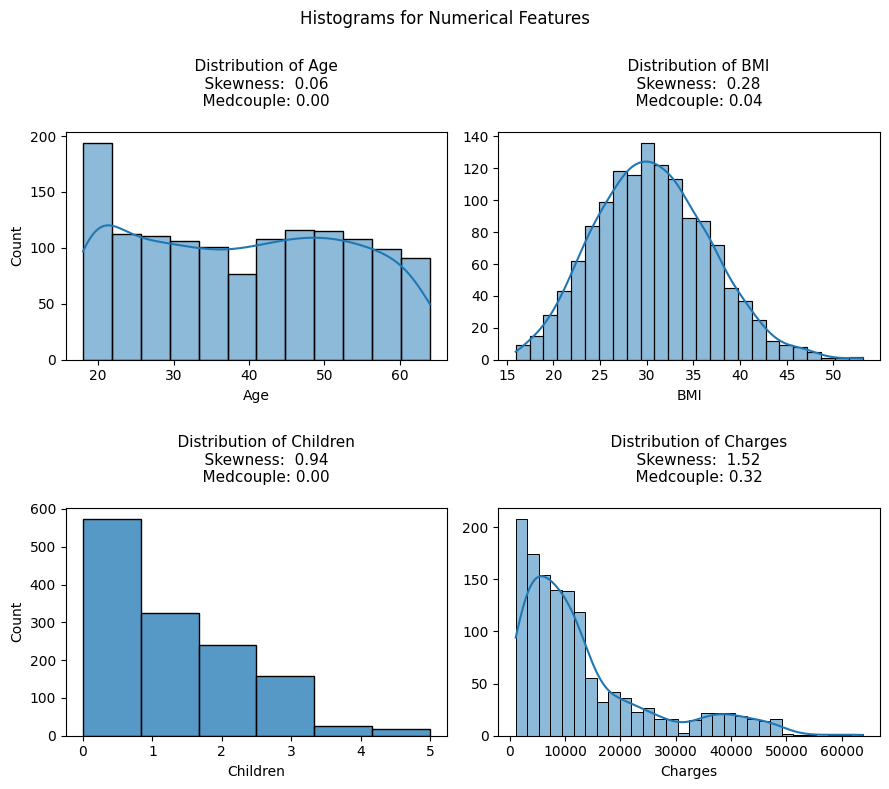

In [836]:
numerical_col = ["age", "bmi", "children", "charges"]
categorical_col = ["sex", "smoker", "region"]

fig, axes = plt.subplots(2, 2, figsize=(9,8))

for ax, col in zip(axes.flatten(), numerical_col, strict=True):

    sns.histplot(insurance_df[col], kde = col!="children", ax=ax, bins = "auto" if col!="children" else 6) # type: ignore
    ax.set_title(f"""
    Distribution of {"BMI" if col == "bmi" else col.title()}
    Skewness:  {insurance_df[col].skew():.2f}
    Medcouple: {medcouple(insurance_df[col]):.2f}
    """, fontsize=11)
    ax.set(xlabel="BMI" if col == "bmi" else col.title(), ylabel="Count" if col in ["age", "children"] else "")

fig.suptitle("Histograms for Numerical Features")
plt.tight_layout()
plt.show()

Now, we inspect the histograms.

- Age - Uniformly distributed with a distinct left mode for the youngest age group.
- BMI - Approximately normaly distributed with slight positive skew.
- Children - Highly positively skewed distribution with a significant portion of the population having no children.
- Charges - Highly positively skewed distiribution with the majority of charges below $15,000.


We will now assess for outliers in our numerical features by determining the percentage of points that lay outside of Tukey's fences.  Since the Charges feature has skewness and medcouple metrics of 1.52 and 0.32 respectively, we will follow industry standards and use medcouple adjusted Tukey's fences for this feature.  The BMI feature appears approximately normaly distributed, though with a skewness of 0.28 we will omit using Z-Score metrics to assess its outliers and utilize Tukey's fences.

In [837]:
results_dict = {}
total = len(insurance_df)

for col in numerical_col:

    fences = tukey_fences(insurance_df[col], adjusted = col == "charges")
    outlier = (insurance_df[col] < fences.inner_lower) | (insurance_df[col] > fences.inner_upper)
    extreme_outlier = (insurance_df[col] < fences.outer_lower) | (insurance_df[col] > fences.outer_upper)
    results_dict[col] = {
        "Percentage Outliers": round((outlier.sum() / total) * 100, 2),
        "Percentage Extreme Outliers": round((extreme_outlier.sum() / total) * 100, 2)
    }

display(pd.DataFrame(results_dict))

,age,bmi,children,charges
Percentage Outliers,0.0,0.67,0.0,0.0
Percentage Extreme Outliers,0.0,0.00,0.0,0.0


We find that only the BMI feature contains any outliers with under one percent of the total number of observations being outliers.

Now, we will view boxplots of our numerical features to further assess their distributions.

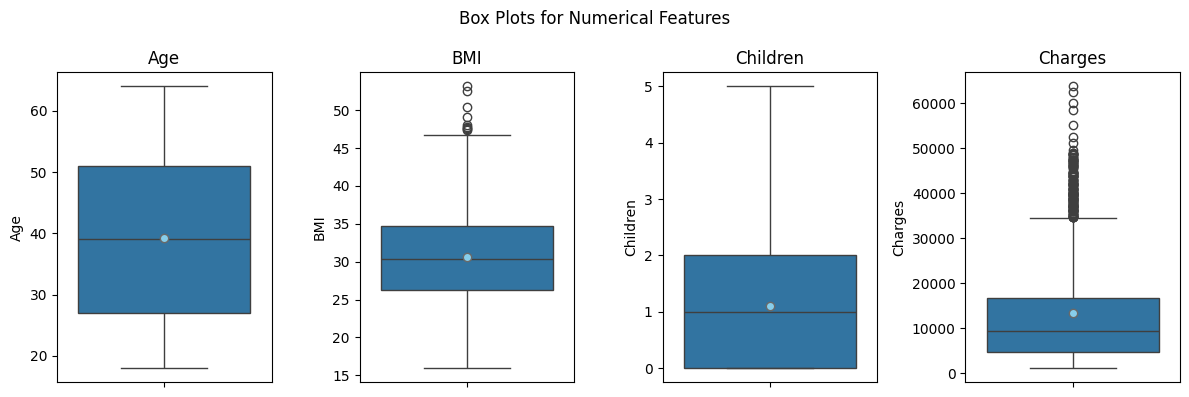

In [838]:
fig, axes = plt.subplots(1, 4, figsize=(12,4))

for ax, col in zip(axes.flatten(), numerical_col, strict=True):

    sns.boxplot(y=insurance_df[col], ax=ax, showmeans=True,
                meanprops={"marker": "o",
                           "markerfacecolor": "skyblue",
                           "markeredgecolor": "dimgray",
                           "markersize": "6"})
    display_col = "BMI" if col == "bmi" else col.title()
    ax.set(title=display_col, ylabel=display_col)

fig.suptitle("Box Plots for Numerical Features")
plt.tight_layout()
plt.show()

Inspection of the boxplots confirms that the Age and Children have no outliers according to Tukey's inner fences, as Seaborn defaults its boxplots to show outliers based on Tukey's inner fences.  We see that the outliers we detected for BMI all lie above the upper inner fence.  The boxplot for Charges shows numerous outliers above the upper inner fence and demonstrates the importance of using adjusted methods for outlier detection for highly skewed distributions.

At this stage, we will now visualize a count of our categorical features.

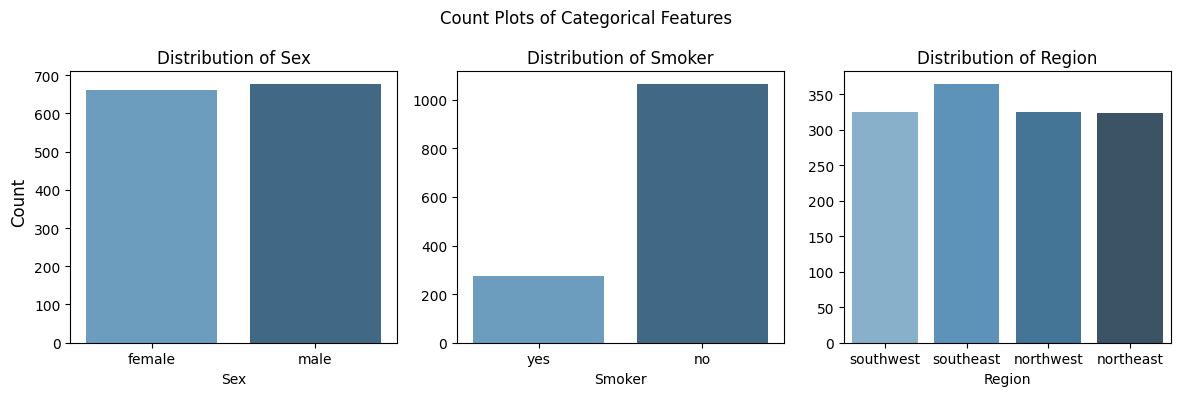

In [839]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, col in zip(axes, categorical_col, strict=True):

    sns.countplot(x=col, data=insurance_df, ax=ax, hue=col, palette="Blues_d")
    ax.set(title=f"Distribution of {col.title()}", xlabel=f"{col.title()}", ylabel="")

fig.supylabel("Count")
fig.suptitle("Count Plots of Categorical Features")
plt.tight_layout()
plt.show()

Viewing the countplots, we find that the Sex and Region features are approximately uniform and the Smoker feature has a high bias to the 'no' class.

Now that we have an idea of how our categorical features are distributed, we investigate how these features are impacting our target feature Charges by viewing bar plots.

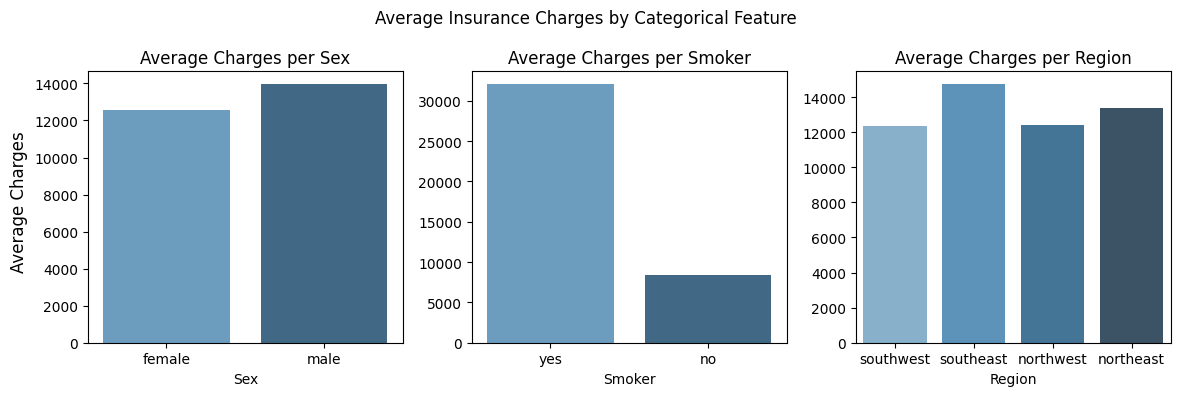

In [840]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, col in zip(axes, categorical_col, strict=True):

    sns.barplot(x=col, y="charges", data=insurance_df, ax=ax, hue=col, palette="Blues_d", errorbar=None)
    ax.set(title=f"Average Charges per {col.title()}", ylabel="", xlabel=f"{col.title()}")

fig.supylabel("Average Charges")
fig.suptitle("Average Insurance Charges by Categorical Feature")
plt.tight_layout()
plt.show()

Inspection of the bar plots reveals that average charge for the Sex and Region features is only slightly effected by their respective classes, which signals low predictive power for the classes within the features.  In contrast, the Smoker feature shows a significant difference in average charges for its classes, signifying that smoker status could be an excellent predictor of charges incured by the individuals.

Knowing that average charges responds well to smoker status, we now view scatterplots of the numerical features of BMI and Age vs Charges, hued by smoker status, to gain insights on the creation of interaction features for our model.

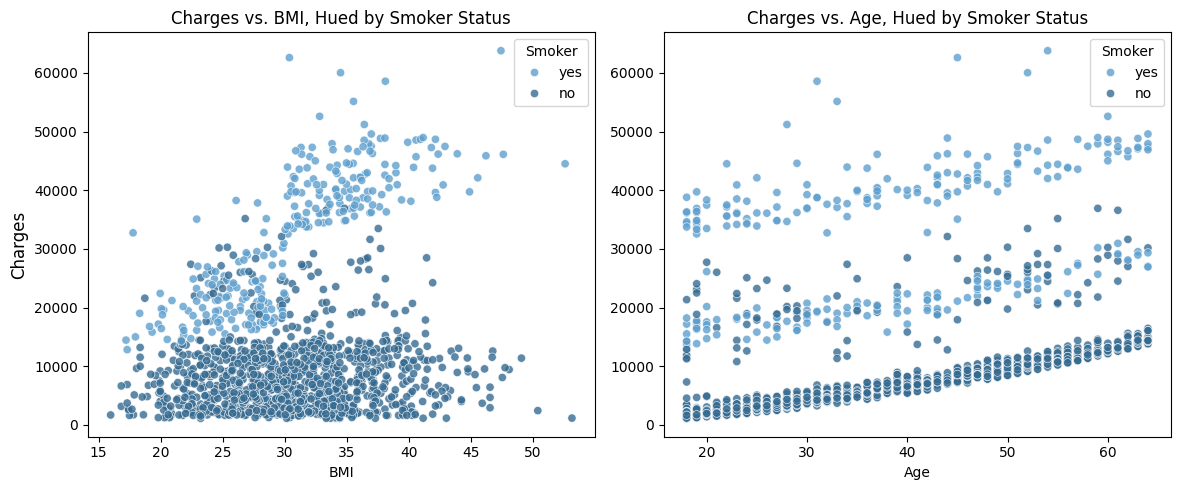

In [841]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, col in zip(axes, ["bmi", "age"], strict=True):

    sns.scatterplot(data=insurance_df, x=col, y="charges", hue="smoker", palette="Blues_d", alpha=0.8, ax=ax)
    display_col = "BMI" if col == "bmi" else "Age"
    ax.set(title=f"Charges vs. {display_col}, Hued by Smoker Status", xlabel=display_col, ylabel="")
    ax.legend(title="Smoker")

fig.supylabel("Charges")
plt.tight_layout()
plt.show()

Viewing the scatterplots, we find that for BMI there is a clear trend for smoker status on Charges; people who smoke incur greater charges than those of non-smokers.  Specifically, there is a sizeable cluster of smokers with BMI's above 30 where the highest charges are incurred, where only a few non-smokers are present.  Based upon these findings, we will create interaction features for both BMI and Smoker and BMI above 30 and Smoker in hopes of increasing the predictive power of our models.  The Age feature also shows a distinctive trend for higher costs incurred for smokers and lower costs for non-smokers; and hence we will also include an interaction feature of Age and Smoker for our predictive models.

### 2.2 Handle Missing Values and Clean Data

During our initial data inspection, we found that there were no missing values in our dataset.  While outliers were detected in the BMI feature, we will choose to not clean them from our dataset as they can still contain valuable information about the variability in our target feature Charges.  (Note: All models were trained with the BMI outliers cleaned and all but the Log Polynomial Model showed significant performance metric degradation.)  To make our categorical features interpritable by our regressors, we now binary encode Smoker and Sex, then one-hot encode Region.

In [842]:
insurance_df["smoker"] = insurance_df["smoker"].map({"yes": 1, "no": 0})
insurance_df["sex"] = insurance_df["sex"].map({"male": 1, "female": 0})

region_dummies = pd.get_dummies(insurance_df["region"], dtype=int, drop_first=True)
insurance_df = pd.concat([insurance_df, region_dummies], axis=1).drop("region", axis=1)

### 2.3 Feature Selection and Engineering

Based upon the findings of our initial EDA, we now create interaction features for BMI and Smoker, Age and Smoker, and BMI over 30 and Smoker.

In [843]:
insurance_df["bmi_smoker"] = insurance_df["bmi"] * insurance_df["smoker"]
insurance_df["age_smoker"] = insurance_df["age"] * insurance_df["smoker"]
insurance_df["obese_smoker"] = ((insurance_df["bmi"] > 30) & (insurance_df["smoker"] == 1)).astype(int)

## Section 3. Feature Selection and Justification

### 3.1 Choose Features and Target

Preliminary inspection and initial EDA of our dataset showed that our target feature Charges was highly positively skewed with a range of $1121.87 to $63,770.43, mean of $13,270.42, and standard deviation of $12,110.01.  These metrics demonstrate significant variability in our target feature suggesting the need for many explanatory predicting features.  Thus, we will choose to use all features of the dataset as predictor features.

### 3.2 Define X and y

Now, we define our input set X and target set y.

In [844]:
X = insurance_df.drop("charges", axis=1)
y = insurance_df["charges"]

## Section 4. Train Linear Regression Model

### 4.1 Split Data

With Linear Regression in mind, we first split our input and target sets into training and test sets.

In [845]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

### 4.2 Train the Model

Then, we train our model on the training sets.

In [846]:
linear_model = LinearRegression().fit(X_train, y_train)

### 4.3 Evaluate Performance

Now, we define a helper function to calculate performance metrics and display the results using a DataFrame for both training and testing sets.  To visually assess model fit, we also generate a Residual vs Actual plot for the test set.  Finally, we evaluate our Linear Regression Model.

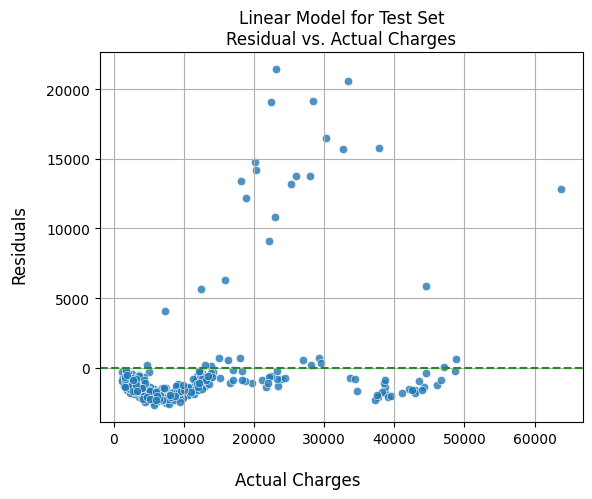

,Model,R²,RMSE,MAE
0,Linear Train,0.864,4425.51,2389.16
1,Linear Test,0.886,4208.77,2315.03


In [847]:
def evaluate_model(name_model):  # noqa: D103
    results = []
    num_plots = len(name_model)
    fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 5))

    for i, (name, model) in enumerate(name_model):

        for tt, (X_tt, y_tt) in zip(("Train", "Test"), ((X_train, y_train), (X_test, y_test)), strict=True):  # noqa: N806

            y_pred = model.predict(X_tt)
            r_sqr = round(r2_score(y_tt, y_pred), 3)
            rmse = round(root_mean_squared_error(y_tt, y_pred), 2)
            mae = round(mean_absolute_error(y_tt, y_pred), 2)
            results.append(
                {
                    "Model": name + " " + tt,
                    "R²": r_sqr,
                    "RMSE": rmse,
                    "MAE": mae
                }
            )
            results_all.append(results[-1])

            if tt == "Test":

                ax = axes[i] if num_plots > 1 else axes
                residuals = y_tt - y_pred
                sns.scatterplot(x=y_tt, y=residuals, alpha=0.8, ax=ax)
                ax.axhline(y=0, color="forestgreen", linestyle="--")
                ax.set(title=f"{name} Model for Test Set\nResidual vs. Actual Charges", xlabel="", ylabel="")
                ax.grid(True)

    fig.supylabel("Residuals")
    fig.supxlabel("Actual Charges")
    plt.tight_layout()
    plt.show()
    display(pd.DataFrame(results))

results_all = []

evaluate_model([("Linear", linear_model)])

### Reflection 4

1) How well did the model perform?
2) Any surprises in the results?

## Section 5. Improve the Model or Try Alternatives

### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression

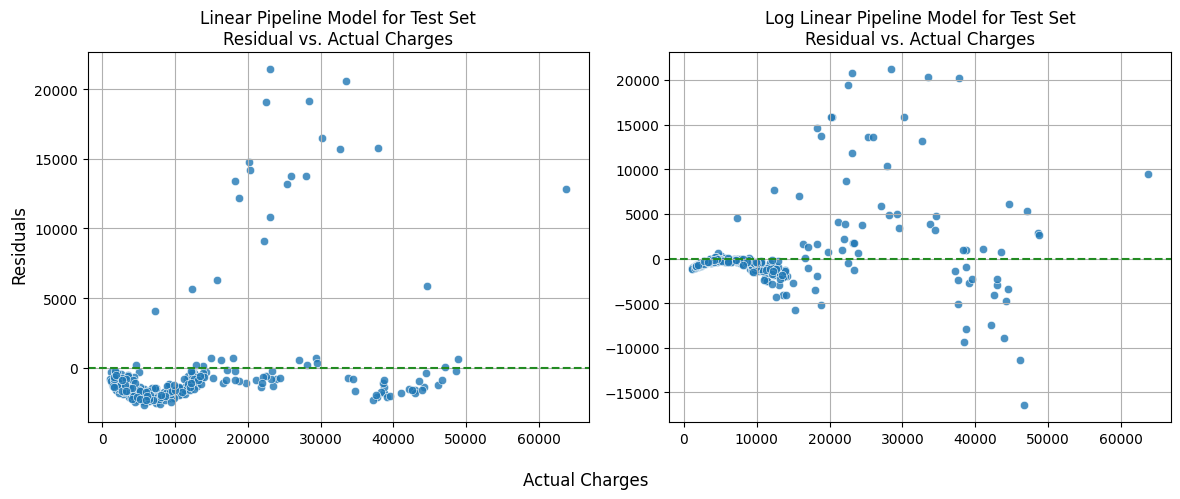

,Model,R²,RMSE,MAE
0,Linear Pipeline Train,0.864,4425.51,2389.16
1,Linear Pipeline Test,0.886,4208.77,2315.03
2,Log Linear Pipeline Train,0.829,4967.96,2473.66
3,Log Linear Pipeline Test,0.863,4610.51,2259.47


In [848]:
pipeline1 = Pipeline([
    ("Imputer", SimpleImputer(strategy="median")),
    ("Scaler", StandardScaler()),
    ("Linear", LinearRegression())
])

pipeline_linear = clone(pipeline1).fit(X_train, y_train)

pipeline_linear_log = TransformedTargetRegressor(
    regressor=clone(pipeline1),
    func=np.log1p,
    inverse_func=np.expm1
).fit(X_train, y_train)

evaluate_model([("Linear Pipeline", pipeline_linear), ("Log Linear Pipeline", pipeline_linear_log)])

### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression

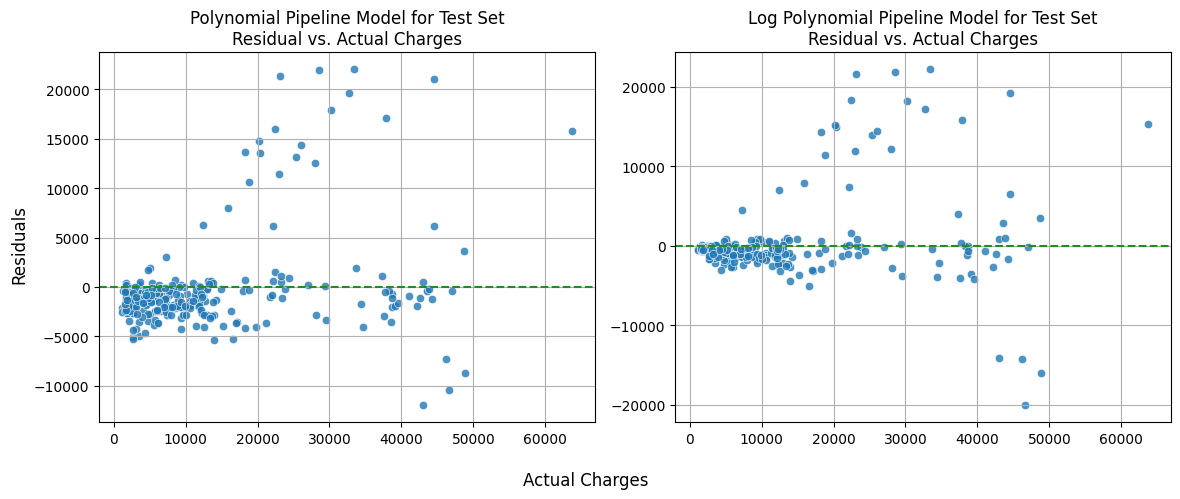

,Model,R²,RMSE,MAE
0,Polynomial Pipeline Train,0.880,4168.10,2354.85
1,Polynomial Pipeline Test,0.848,4856.92,2776.89
2,Log Polynomial Pipeline Train,0.873,4280.57,1977.27
3,Log Polynomial Pipeline Test,0.843,4935.53,2349.62


In [849]:
pipeline2 = Pipeline([
    ("Imputer", SimpleImputer(strategy="median")),
    ("Polynomial", PolynomialFeatures(degree=3, include_bias=False)),
    ("Scaler", StandardScaler()),
    ("Linear", LinearRegression())
])

pipeline_polynomial = clone(pipeline2).fit(X_train, y_train)

pipeline_polynomial_log = TransformedTargetRegressor(
    regressor=clone(pipeline2),
    func=np.log1p,
    inverse_func=np.expm1
).fit(X_train, y_train)

evaluate_model([("Polynomial Pipeline", pipeline_polynomial), ("Log Polynomial Pipeline", pipeline_polynomial_log)])

### 5.3 Compare Model Performance

In [850]:
display(pd.DataFrame(results_all))

,Model,R²,RMSE,MAE
0,Linear Train,0.864,4425.51,2389.16
1,Linear Test,0.886,4208.77,2315.03
2,Linear Pipeline Train,0.864,4425.51,2389.16
3,Linear Pipeline Test,0.886,4208.77,2315.03
4,Log Linear Pipeline Train,0.829,4967.96,2473.66
5,Log Linear Pipeline Test,0.863,4610.51,2259.47
6,Polynomial Pipeline Train,0.880,4168.10,2354.85
7,Polynomial Pipeline Test,0.848,4856.92,2776.89
8,Log Polynomial Pipeline Train,0.873,4280.57,1977.27
9,Log Polynomial Pipeline Test,0.843,4935.53,2349.62


### Reflection 5

1) Which models performed better?
2) How does scaling impact results?

## Section 6. Final Thoughts & Insights

### 6.1 Findings Summary


### 6.2 Challenges Faced

### 6.3 Next Steps